# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq', 'msdai']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot, ts_train_test_normalize


name = 'LSTM_univariate2_classification2'

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')
# %% read in data and adapt
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
target_column = list(df.columns).index(target)
# df = df.loc[(df.iloc[:, :4] != 0).all(axis=1)]
df_close = get_fx_and_metric_data_wo_weekend(dtype=dtype, pct_change=False)
df = df.iloc[:, target_column : target_column + 1]

In [3]:
np.random.seed(42)
# df = df.iloc[np.random.choice(list(range(df.shape[0])), size=df.shape[0], replace=False), :]


In [4]:
# create a list of our conditions #!!! 
conditions = [
    (df[target] <= -0.00000001),
    (df[target] > -0.00000001) & (df[target] <= 0.00000001),
    (df[target] > 0.00000001)
]

# create a list of the values we want to assign for each condition #!!! 
values = ['sell', 'hold', 'buy']
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments #!!! 
df['strategy'] = np.select(conditions, values)
df.strategy = df.strategy.astype(np.int32)

# display updated DataFrame #!!! 
df.head()

,EURUSD BGNE Curncy Bid Close,strategy
Dates,,
2020-11-01 19:10:00,0.000000,1
2020-11-01 19:20:00,0.000275,2
2020-11-01 19:30:00,-0.000069,0
2020-11-01 19:40:00,0.000034,2
2020-11-01 19:50:00,0.000026,2


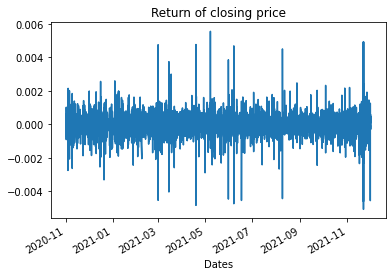

In [5]:
df['EURUSD BGNE Curncy Bid Close'].plot()
plt.title('Return of closing price')
plt.show()

In [6]:
lag = 256
h = 1
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, df.columns.to_list().index('strategy'), dtype=dtype)

In [7]:
print(index_train.shape)
print(X_train.shape)
print(y_train.shape)

(33562,)
(33305, 256, 2)
(33305, 1)


In [8]:
a = np.array([sc.inverse_transform(X_train[i,:]) for i in range(X_train.shape[0])])
b = np.concatenate([sc.inverse_transform(X_train[:,i])[:,np.newaxis] for i in range(lag)], axis=1)
a.shape == b.shape
np.abs(a - b).sum()

0.0

In [9]:
np.abs(a[:,-1] - df.loc[index_train].iloc[lag - 1:-2].values).sum()

0.002651539101570699

In [10]:
# assert ((df.values[:X_train.shape[0]] - sc.inverse_transform(X_train)[:,0])**2).sum() < 1e-10
# assert ((df.values[lag - 1:lag - 1 + X_train.shape[0]] - sc.inverse_transform(X_train)[:,-1])**2).sum() < 1e-10

# assert ((df.iloc[-X_test.shape[0] - lag - h:][:-lag - h].values - sc.inverse_transform(X_test)[:,0])**2).sum() < 1e-11
# assert index_test[0] == df.iloc[-X_test.shape[0] - lag - h:].index[0]
# for i in range(lag):
#     assert ((df.iloc[-X_test.shape[0] - lag - h:][i:-(lag + h -i)].values - sc.inverse_transform(X_test)[:,i])**2).sum() < 1e-10

# assert (sc_target.inverse_transform(X_train[:, 0, 1]) == df.iloc[:X_train.shape[0], 1].values).all()
# assert (sc_target.inverse_transform(X_train[:, -1, 1]) == df.iloc[lag - 1:lag - 1 + X_train.shape[0], 1].values).all()

# assert (sc_target.inverse_transform(X_val[:, 0, 1]) == df.iloc[X_train.shape[0] + lag + 1: lag + 1 + X_train.shape[0] + X_val.shape[0], 1].values).all()
# assert (sc_target.inverse_transform(X_val[:, -1, 1]) == df.iloc[X_train.shape[0] + lag + 1 + lag - 1: lag + 1 + lag - 1 + X_train.shape[0] + X_val.shape[0], 1].values).all()
# # # assert (sc_target.inverse_transform(X_val[:, -1, 1]) == df.iloc[127:127 + X_train.shape[0], 1].values).all()
# # print(sc.inverse_transform(X_test)[-10:, :4, 0])
# # print(index_test[-4:])
# # df.iloc[-10:, 0]
# a = (sc.inverse_transform(X_train)[:, 0] == df.iloc[:23081])
# np.sum((df.iloc[:23081].loc[np.invert(a).iloc[:, 0]] - sc.inverse_transform(X_train)[np.invert(a).iloc[:, 0], 0]) ** 2)


In [11]:
X_train = X_train#.astype(dtype)
X_val = X_val#.astype(dtype)
X_test = X_test#.astype(dtype)
y_train = sc_target.inverse_transform(y_train).round()
y_val = sc_target.inverse_transform(y_val).round()
y_test = sc_target.inverse_transform(y_test).round()

In [12]:
def LSTM_model():
    # The LSTM architecture
    act_fct = 'tanh'
    dr = 0.5
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=act_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
#     my_LSTM_model.add(Dense(units=128, activation=loss_fct))
#     my_LSTM_model.add(Dropout(0.25))
    my_LSTM_model.add(Dense(units=3, activation='softmax'))
    return my_LSTM_model

In [13]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [14]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [15]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(
        learning_rate=0.05
    ),
    loss=SparseCategoricalCrossentropy(from_logits=False),
#     loss='accuracy',
    metrics=['kullback_leibler_divergence', 'accuracy'],
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/100
1041/1041 [==============================] - 42s 36ms/step - loss: 1.4641 - kullback_leibler_divergence: 4.4246 - accuracy: 0.4800 - val_loss: 0.8427 - val_kullback_leibler_divergence: 2.6125 - val_accuracy: 0.4891

Epoch 00001: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0001.hdf5
Epoch 2/100
1041/1041 [==============================] - 37s 36ms/step - loss: 0.8341 - kullback_leibler_divergence: 2.8289 - accuracy: 0.4852 - val_loss: 0.8852 - val_kullback_leibler_divergence: 2.6208 - val_accuracy: 0.4619

Epoch 00002: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0002.hdf5
Epoch 3/100
1041/1041 [==============================] - 37s 35ms/step - loss: 0.8418 - kullback_leibler_divergence: 2.8773 - accuracy: 0.4898 - val_loss: 0.8878 - val_kullback_leibler_divergence: 3.0691 - val_accuracy: 0.4863

Epoch 00003: saving model to Benchmark/trained_models/LSTM_univariate2_classification____0003.hdf5
Epoch 4/100
1041/10

In [16]:
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [17]:
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last),
        custom_objects={'kl_divergence': kullback_leibler_divergence}
    )
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history

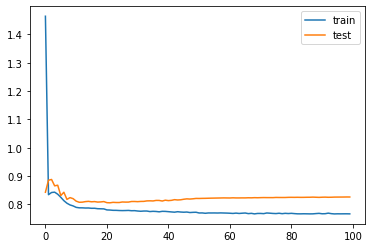

In [18]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

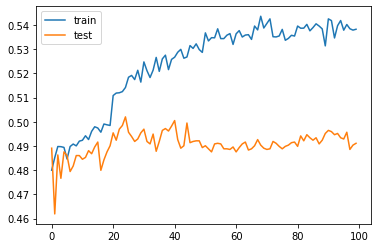

In [19]:
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [20]:
y_pred = my_LSTM_model.predict(X_train).argmax(axis=1)

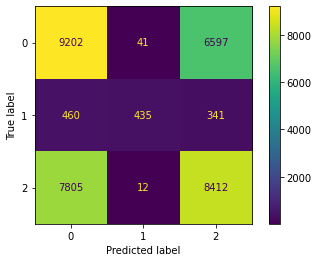

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(cm).plot()

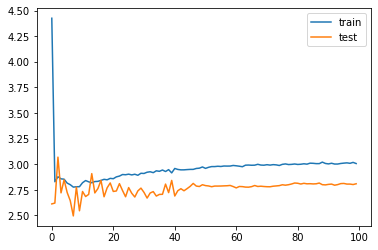

In [23]:
plt.plot(history['kullback_leibler_divergence'], label='train')
plt.plot(history['val_kullback_leibler_divergence'], label='test')
plt.legend()
plt.show()

In [24]:
my_LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256, 64)           17152     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64)           256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 256, 64)           33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 64)           256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 256, 64)           33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 64)           256       
_________________________________________________________________
lstm_3 (LSTM)                (None, 256, 64)           3

In [25]:
opt_learn_rate_plot(
    my_LSTM_model,
    X_train[..., :1],
    y_train,
    10**-6,
    10**1,
    100,
    batch_size=64,
    steps_per_epoch=1,
    custom_objects={'kl_divergence': kullback_leibler_divergence}
)

Epoch 1/100


ValueError: in user code:

    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:860 train_function  *
        return step_function(self, iterator)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:850 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2844 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3619 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:843 run_step  **
        outputs = model.train_step(data)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:800 train_step
        y_pred = self(x, training=True)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 2), found shape=(None, 256, 1)


## Econmetric measures

Definition of cumulated returns

In [26]:
def cumulated_return(y_pred, ret, start_capital=1000, dtype=None):
    assert y_pred.flatten().shape == ret.flatten().shape
    balance = [start_capital]
    signal = 0
    for i, d in enumerate(y_pred[:-1]):
        signal = signal if d == 1 else d
        if signal == 0:
            balance.append(balance[-1])
        elif signal == 2:
            balance.append(balance[-1] * ret[i])
        else:
            raise ValueError()
    balance = np.array(balance, dtype=dtype)
    return balance

In [27]:
X_train.shape

(33305, 256, 2)

In [28]:
#!!! for testing purposes
tmp_type = 'train'

X = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)
for i in range(lag):
    diff = np.abs(df.loc[eval(f"index_{tmp_type}")].iloc[i:-(lag - i + 1)].values - X[:,-(lag - i)]).sum(axis=0)
    assert diff[0] < 1e-6 and diff[1] < 0.5, 'df and X inversed are not the same'

X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0]
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]

a = sc_target.inverse_transform(eval(f"y_{tmp_type}")).flatten()
b = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1]
cc = df.loc[eval(f"index_{tmp_type}")].iloc[127:-2, 1].values
print(np.abs(cc[1:] - a[:-1]).sum(axis=0))
print(np.abs(cc - b).sum(axis=0))

ValueError: operands could not be broadcast together with shapes (33432,) (33304,) 

In [ ]:
print((index_train[0:-129] == X_train_index[:, 0]).all())
print((index_train[127:-2] == X_train_index[:, -1]).all())

## read in data for econmic metric

In [ ]:
tmp_type = 'train'
X_ret_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 0] + 1
y_testing = np.concatenate([sc.inverse_transform(i)[np.newaxis] for i in eval(f"X_{tmp_type}")], axis=0)[:, -1, 1].round()

df_testing = df.loc[eval(f"index_{tmp_type}")].iloc[127:-2]
df_close_testing = df_close.loc[eval(f"index_{tmp_type}")].iloc[127:-2]
X_ret_testing.shape[0] == df_testing.shape[0]

In [29]:
assert np.abs(cumulated_return(y_testing, X_ret_testing) - \
              cumulated_return(df_testing.values[:, 1], df_testing.values[:, 0] + 1)).sum() < 1e-10, "cumulated return of df and X are not the same"

ValueError: 

In [30]:
# Test eq
print((np.equal((y_testing.flatten() == 0), X_ret_testing -1 < - 0.00000001)).mean())
print((np.equal((y_testing.flatten() == 1), np.logical_and(X_ret_testing -1 >= -0.00000001, X_ret_testing -1 < 0.00000001 ))).mean())
print((np.equal((y_testing.flatten() == 2), X_ret_testing -1 >= 0.00000001)).mean())

print((np.equal((df_testing.values[:, 1] == 0), df_testing.values[:, 0] < -0.00000001)).mean())
print((np.equal((df_testing.values[:, 1] == 1), np.logical_and(df_testing.values[:, 0] >= -0.00000001, df_testing.values[:, 0] < 0.00000001 ))).mean())
print((np.equal((df_testing.values[:, 1] == 2), df_testing.values[:, 0] >= 0.00000001)).mean())

0.0
0.9628884551869089
1.0


NameError: name 'df_testing' is not defined

In [31]:
# y_pred = predictions(
#     my_LSTM_model,
#     eval(f"X_{tmp_type}")[..., :1]
# )
# y_pred = np.argmax(y_pred, axis=1)
from copy import deepcopy
y_pred = deepcopy(y_testing)
np.random.shuffle(y_pred)

In [32]:
for _ in range(10):
    np.random.shuffle(y_pred)
    plt.plot(cumulated_return(y_pred, X_ret_testing, 1000), color='grey', lw=0.5)
a = cumulated_return(y_testing, X_ret_testing, 1000)
plt.plot(a[1:], label='cumulated_return')
a = cumulated_return(y_train, X_ret_testing, 1000)
plt.plot(a[1:], label='y_train')
plt.semilogy()
plt.legend()
plt.show()

ValueError: 

In [33]:
df.columns

Index(['EURUSD BGNE Curncy Bid Close', 'strategy'], dtype='object')

In [34]:
if tmp_type == 'train':
    df_tmp = df.loc[X_train_index[:, -1]].loc[:, target].values + 1
    df_close_tmp = df_close.loc[X_train_index[:, -1]].iloc[:, target_column : target_column + 1].values
    print(df_close_tmp[-1] / df_close_tmp[0] * 1000)
    print(df_tmp.prod() * 1000)
    print(X_ret_testing.prod() * 1000)
    print(cumulated_return(y_testing * 0 + 2, X_ret_testing, 1000)[-1])

KeyError: "None of [Float64Index([ 1.604410803224576e+18,   1.60441135298039e+18,\n              1.6044120401751572e+18, 1.6044125899309711e+18,\n               1.604413139686785e+18, 1.6044138268815524e+18,\n              1.6044143766373663e+18, 1.6044150638321336e+18,\n              1.6044156135879475e+18, 1.6044161633437614e+18,\n              ...\n              1.6315452383695995e+18, 1.6315457881254134e+18,\n              1.6315463378812273e+18, 1.6315470250759946e+18,\n              1.6315475748318085e+18,  1.631548262026576e+18,\n              1.6315488117823898e+18, 1.6315493615382036e+18,\n               1.631550048732971e+18,  1.631550598488785e+18],\n             dtype='float64', name='Dates', length=33305)] are in the [index]"

In [35]:
print(X_ret_testing[1::3].prod()* 1000)
y_tmp = y_testing[1:] * 1
y_tmp[1::3] = 2
print(cumulated_return(y_tmp, X_ret_testing[1:], 1000)[-1])
y_tmp = y_train * 1
y_tmp[1::3] = 2
print(cumulated_return(y_tmp[:-1], X_ret_testing[1:], 1000)[-1])

-0.0


ValueError: 

In [36]:
tmp_type = 'train'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


train


ValueError: in user code:

    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1579 predict_function  *
        return step_function(self, iterator)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2844 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3619 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1562 run_step  **
        outputs = model.predict_step(data)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1535 predict_step
        return self(x, training=False)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 2), found shape=(None, 256, 1)


In [37]:
tmp_type = 'val'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


val


ValueError: in user code:

    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1579 predict_function  *
        return step_function(self, iterator)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2844 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3619 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1562 run_step  **
        outputs = model.predict_step(data)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1535 predict_step
        return self(x, training=False)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1040 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ms/github/venv/fxpred3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, None, 2), found shape=(None, 256, 1)


In [ ]:
tmp_type = 'test'
print(tmp_type)

y = eval(f"y_{tmp_type}")
y_pred = np.argmax(predictions(
    my_LSTM_model,
    eval(f"X_{tmp_type}")[..., :1]
), axis=1)
# actual_pred_plot(y_pred, eval(f'y_{tmp_type}'))
# plt.show()
print(f'Accuracy: {Accuracy()(y.flatten(), y_pred.flatten()).numpy()}')
print(f'Accuracy: {SparseCategoricalAccuracy()(y.astype(dtype), y_pred.reshape(y.shape).astype(dtype)).numpy()}')
print(f'KL_Divergence: {kullback_leibler_divergence(y.flatten().astype(dtype), y_pred.flatten().astype(dtype)).numpy()}')
print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))

X_ret = sc.inverse_transform(eval(f"X_{tmp_type}"))[:, -1, 0] + 1
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype), label='predicted')

p = [i[1]/y.shape[0] for i in sorted(Counter(y.flatten()).items(), key=lambda x: x[0])]
x = np.concatenate(
    [
        cumulated_return(
            np.random.choice([0, 1, 2], size=y_pred[:-1].shape, p=p),
            X_ret[1:],
            dtype=dtype
        )[:,np.newaxis] for i in range(50)
    ], axis=-1
)
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1), label='random', color='gray')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], x.mean(axis=-1) + x.std(axis=-1), label='random_q75', color='gray', linestyle='--')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y_pred[:-1] * 0 + 2, X_ret[1:], dtype=dtype), label='buy&HODL')
plt.plot(eval(f"index_{tmp_type}")[127:-2][1:], cumulated_return(y[:-1], X_ret[1:], dtype=dtype), label='oracle')
plt.legend()
plt.semilogy()
plt.show()


cumulated_return(y_pred, X_ret, dtype=dtype)

In [ ]:
x = cumulated_return(y_pred[:-1], X_ret[1:], dtype=dtype)

(x[-1] / x[0]) / (np.std(x[1:] / x[:-1]) * np.sqrt(6 * 24 * 250))

In [ ]:
# ax1 = fig.add_subplot(211)
# ax1.plot(index_train[X_train.shape[1]:], df_train[target], label='Training data')
# ax1.plot(index_val[X_train.shape[1]:], df_val[target], label='Validation data')
# ax1.plot(index_test[X_train.shape[1]:], df_test[target], label='Test data')
# ax1.set_xlabel('Dates')
# ax1.set_ylabel('Normalized Closing Returns')
# ax1.set_title("Close Price", fontsize=18)
# ax1.legend(loc="best", fontsize=12)